# Extract, Load, Filter

In [1]:
import pandas as pd
import zipfile
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats
import numpy as np

### Extract ###

# Define path to the zip file
zip_path = 'fr.openfoodfacts.org.products.csv.zip'

# Define path to the csv file you want to extract
csv_path = 'fr.openfoodfacts.org.products.csv'

unzip = False

# Open and extract the csv file
if unzip:
    with zipfile.ZipFile(zip_path, 'r') as zfile:
        zfile.extract(csv_path)

### Load ###

# Now we can read the extracted csv file into a DataFrame
df = pd.read_csv(csv_path, delimiter="\t", low_memory=False)

### Filter ###

# Drop 100% missing values
df.dropna(how="all", axis="columns", inplace=True)

for col in df.columns.to_list():

    # assuming df is your DataFrame and 'column1' is your column
    missing_values_count = df[col].isnull().sum()
    total_values = len(df[col])

    if missing_values_count / total_values > 0.5:
        print(f"More than 50% of the values in {col} are missing.")
        df.drop(col, axis="columns", inplace=True)

    else:
        print(f"Less than or equal to 50% of the values in {col} are missing.")

Less than or equal to 50% of the values in code are missing.
Less than or equal to 50% of the values in url are missing.
Less than or equal to 50% of the values in creator are missing.
Less than or equal to 50% of the values in created_t are missing.
Less than or equal to 50% of the values in created_datetime are missing.
Less than or equal to 50% of the values in last_modified_t are missing.
Less than or equal to 50% of the values in last_modified_datetime are missing.
Less than or equal to 50% of the values in product_name are missing.
More than 50% of the values in generic_name are missing.
More than 50% of the values in quantity are missing.
More than 50% of the values in packaging are missing.
More than 50% of the values in packaging_tags are missing.
Less than or equal to 50% of the values in brands are missing.
Less than or equal to 50% of the values in brands_tags are missing.
More than 50% of the values in categories are missing.
More than 50% of the values in categories_tags 

In [2]:
# define relevant variables
variables = df.columns.to_list()
int_cols = df.select_dtypes(include=[int]).columns.tolist()
float_cols = df.select_dtypes(include=[float]).columns.tolist()

ignore_cols = ["nutrition-score-fr_100g",  "nutrition-score-uk_100g", 
               "additives_n", "ingredients_from_palm_oil_n",
               "ingredients_that_may_be_from_palm_oil_n"]

# create an imputer object for numeric and categorical columns
numeric_imputer = SimpleImputer(strategy='median') # Median to acccount for the fact outliers are within data
categorical_imputer = SimpleImputer(strategy='most_frequent') # Most frequent because quick and easy

missing_value_threshold = 0.5
upper_limit = 0.75
lower_limit = 0.25
factor = 1.5

for column in variables:
    missing_values_count = df[column].isnull().sum()
    total_values = len(df[column])
    if missing_values_count / total_values <= missing_value_threshold:
        print(f"More than 50% of the values in '{column}' are missing.")
        if (column in int_cols) or (column in float_cols):
            df[column] = numeric_imputer.fit_transform(df[column].values.reshape(-1, 1))

            if (column in float_cols) & (column not in ignore_cols):
                Q1 = df[column].quantile(lower_limit)
                Q3 = df[column].quantile(upper_limit)
                IQR = Q3 - Q1
                lower_fence = Q1 - (factor*IQR)
                upper_fence = Q3 + (factor*IQR)
                df[column].clip(upper=upper_fence, lower=lower_fence, inplace=True)
        else:
            df[column] = categorical_imputer.fit_transform(df[column].values.reshape(-1, 1))
    else:
        print(f"Less than or equal to 50% of the values in '{column}' are missing.")
        df.drop(col, axis="columns", inplace=True)


More than 50% of the values in 'code' are missing.
More than 50% of the values in 'url' are missing.
More than 50% of the values in 'creator' are missing.
More than 50% of the values in 'created_t' are missing.
More than 50% of the values in 'created_datetime' are missing.
More than 50% of the values in 'last_modified_t' are missing.
More than 50% of the values in 'last_modified_datetime' are missing.
More than 50% of the values in 'product_name' are missing.
More than 50% of the values in 'brands' are missing.
More than 50% of the values in 'brands_tags' are missing.
More than 50% of the values in 'countries' are missing.
More than 50% of the values in 'countries_tags' are missing.
More than 50% of the values in 'countries_fr' are missing.
More than 50% of the values in 'ingredients_text' are missing.
More than 50% of the values in 'serving_size' are missing.
More than 50% of the values in 'additives_n' are missing.
More than 50% of the values in 'additives' are missing.
More than 50%

# Univariate Analaysis

In [3]:
df["ingredients_from_palm_oil_n"].unique()

array([0., 1., 2.])

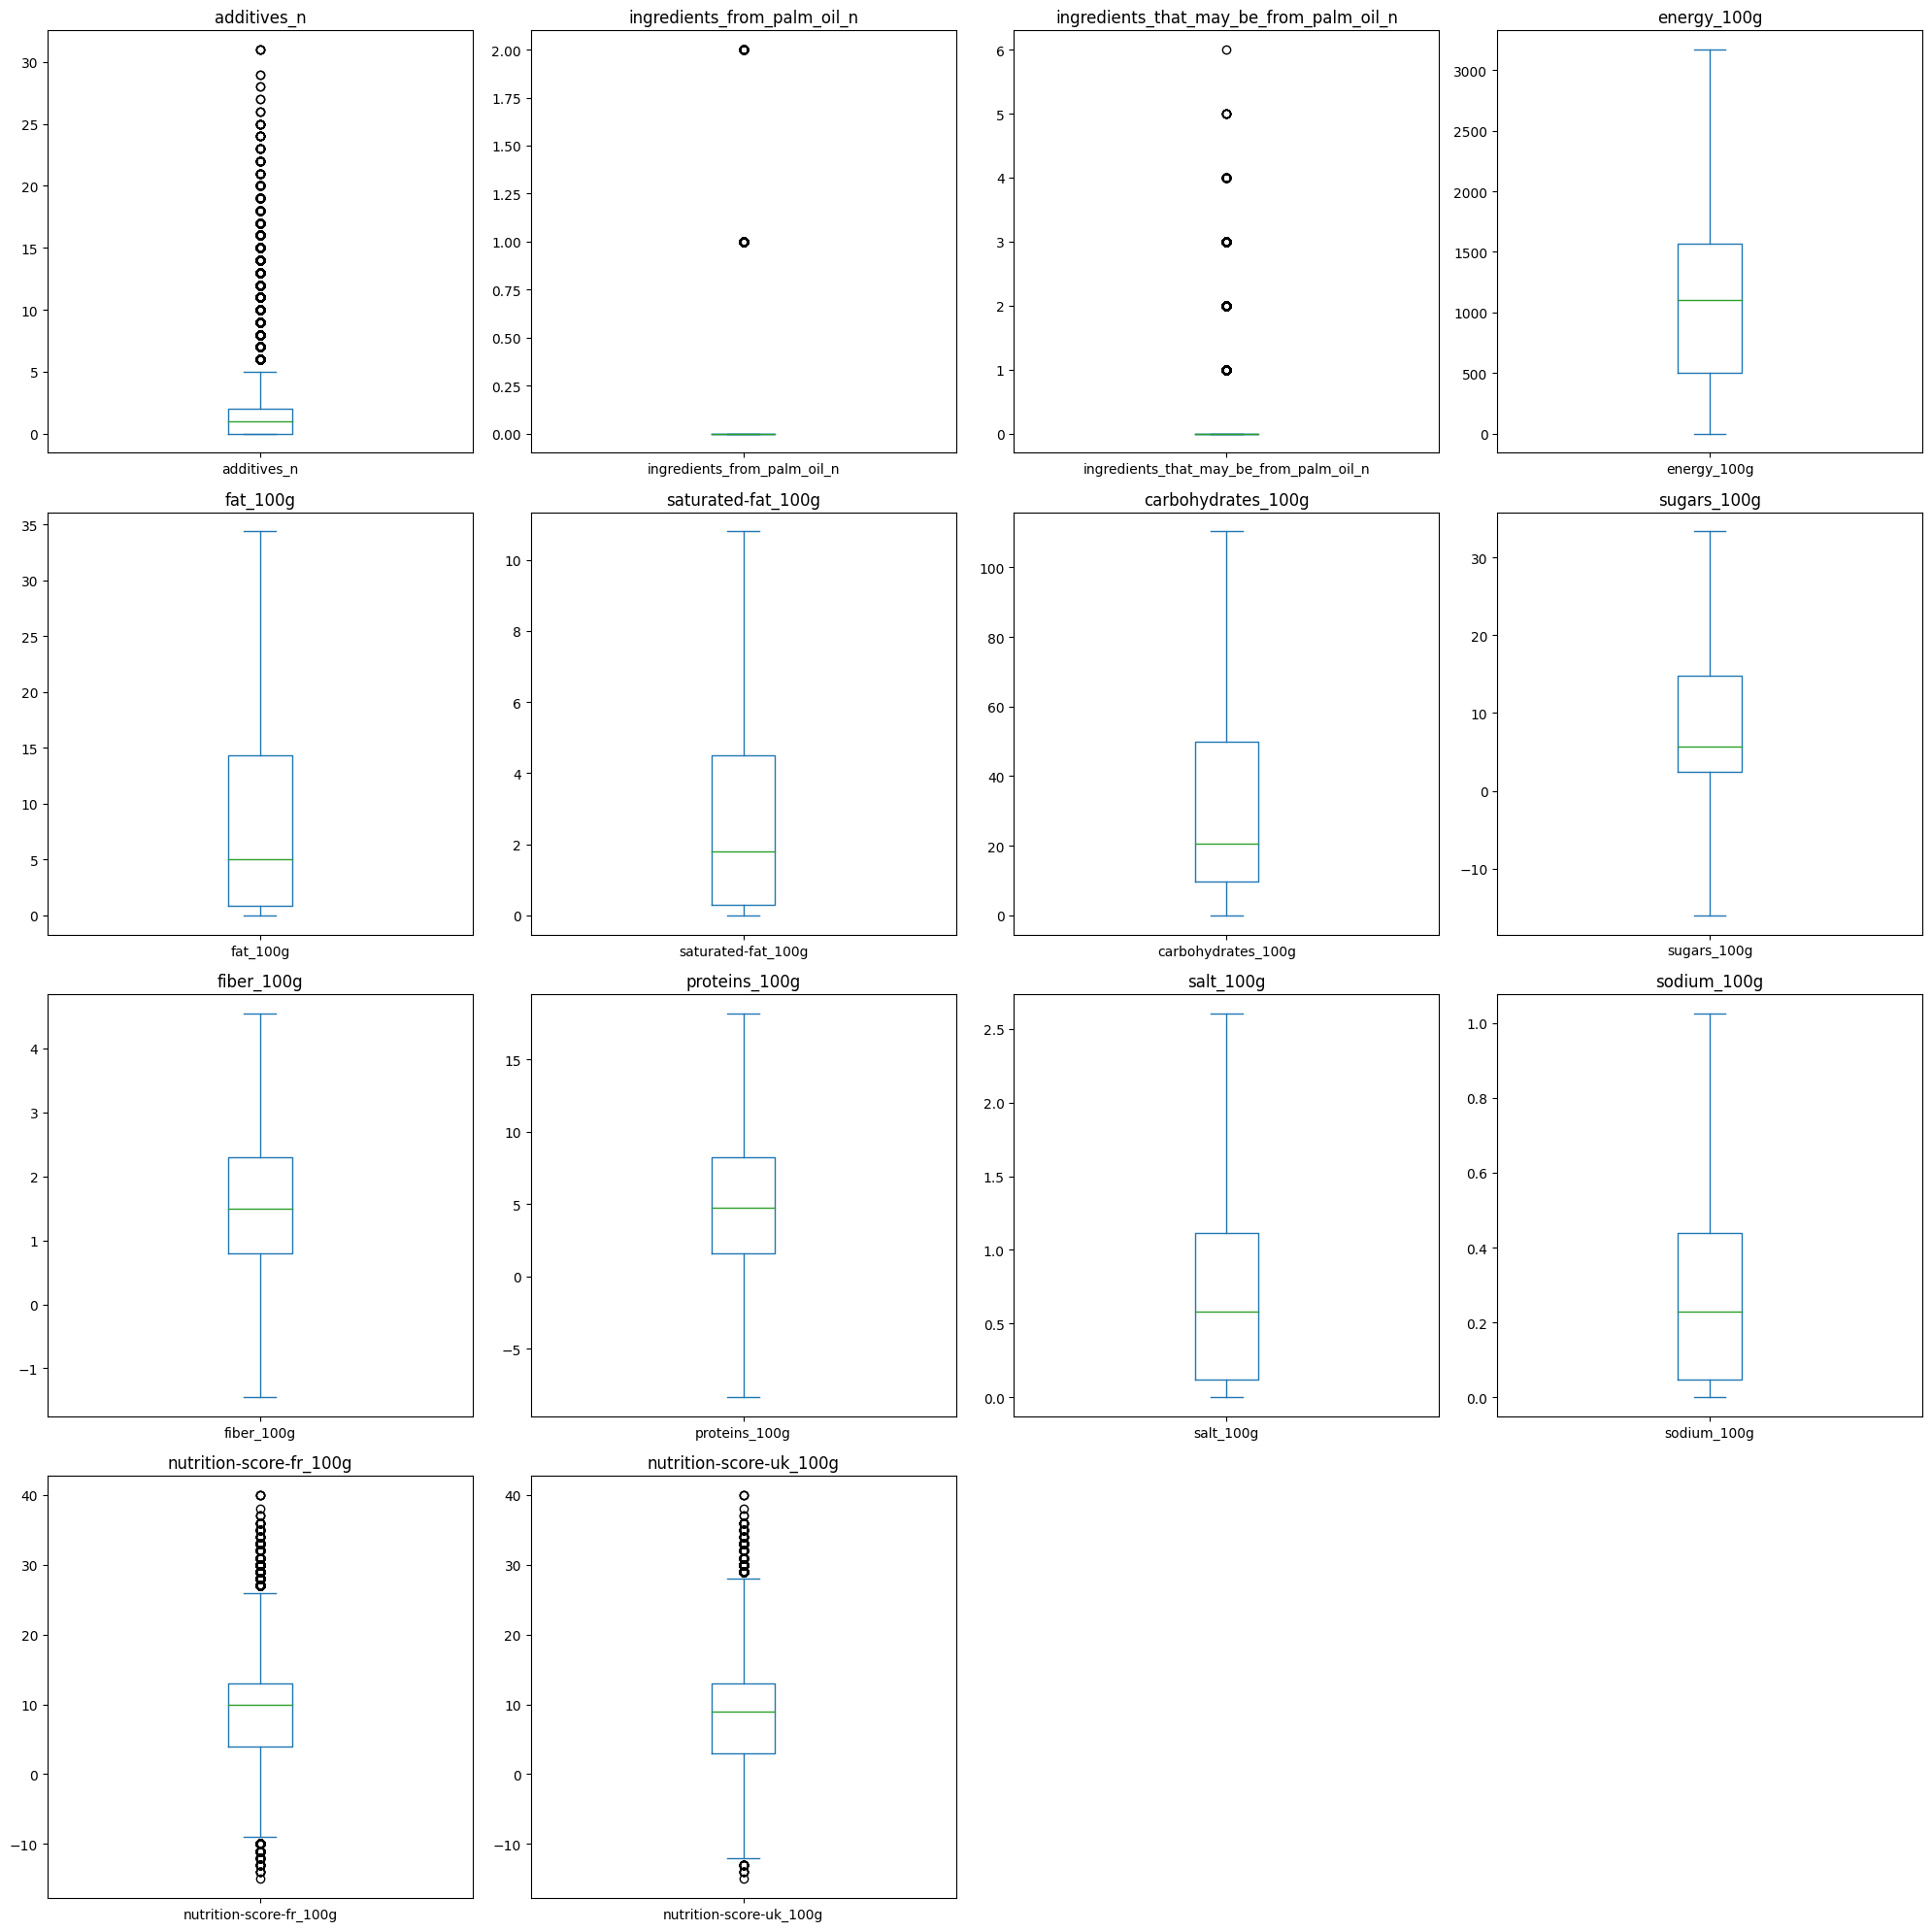

In [4]:
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate number of rows needed for subplots
n = len(numeric_cols)
n_rows = n//4 if n%4 == 0 else n//4 + 1

fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*5))

for ax, col in zip(axes.flatten(), numeric_cols):
    df[col].plot(kind='box', ax=ax)
    ax.set_title(col)

# Remove empty subplots
if n % 4:
    for i in range(n, n_rows*4):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


In [6]:
df["nutrition-score-fr_100g"].unique()

array([ 10.,  14.,   0.,  12.,   7.,  -6.,  15.,  11.,   9.,  16.,  19.,
        -1.,   6.,  26.,  13.,  17.,  22.,  23.,  30.,   8.,  25.,  -2.,
         1.,   2.,  18.,  21.,  20.,   3.,   4.,  24.,  27.,  28.,  -3.,
        -4.,  -7.,  -5.,   5.,  29.,  31.,  -8.,  -9.,  35.,  33.,  32.,
        34., -10.,  40.,  37.,  38., -11.,  36., -13., -12., -14., -15.])

array([[<Axes: title={'center': 'additives_n'}>,
        <Axes: title={'center': 'ingredients_from_palm_oil_n'}>,
        <Axes: title={'center': 'ingredients_that_may_be_from_palm_oil_n'}>,
        <Axes: title={'center': 'energy_100g'}>],
       [<Axes: title={'center': 'fat_100g'}>,
        <Axes: title={'center': 'saturated-fat_100g'}>,
        <Axes: title={'center': 'carbohydrates_100g'}>,
        <Axes: title={'center': 'sugars_100g'}>],
       [<Axes: title={'center': 'fiber_100g'}>,
        <Axes: title={'center': 'proteins_100g'}>,
        <Axes: title={'center': 'salt_100g'}>,
        <Axes: title={'center': 'sodium_100g'}>],
       [<Axes: title={'center': 'nutrition-score-fr_100g'}>,
        <Axes: title={'center': 'nutrition-score-uk_100g'}>, <Axes: >,
        <Axes: >]], dtype=object)

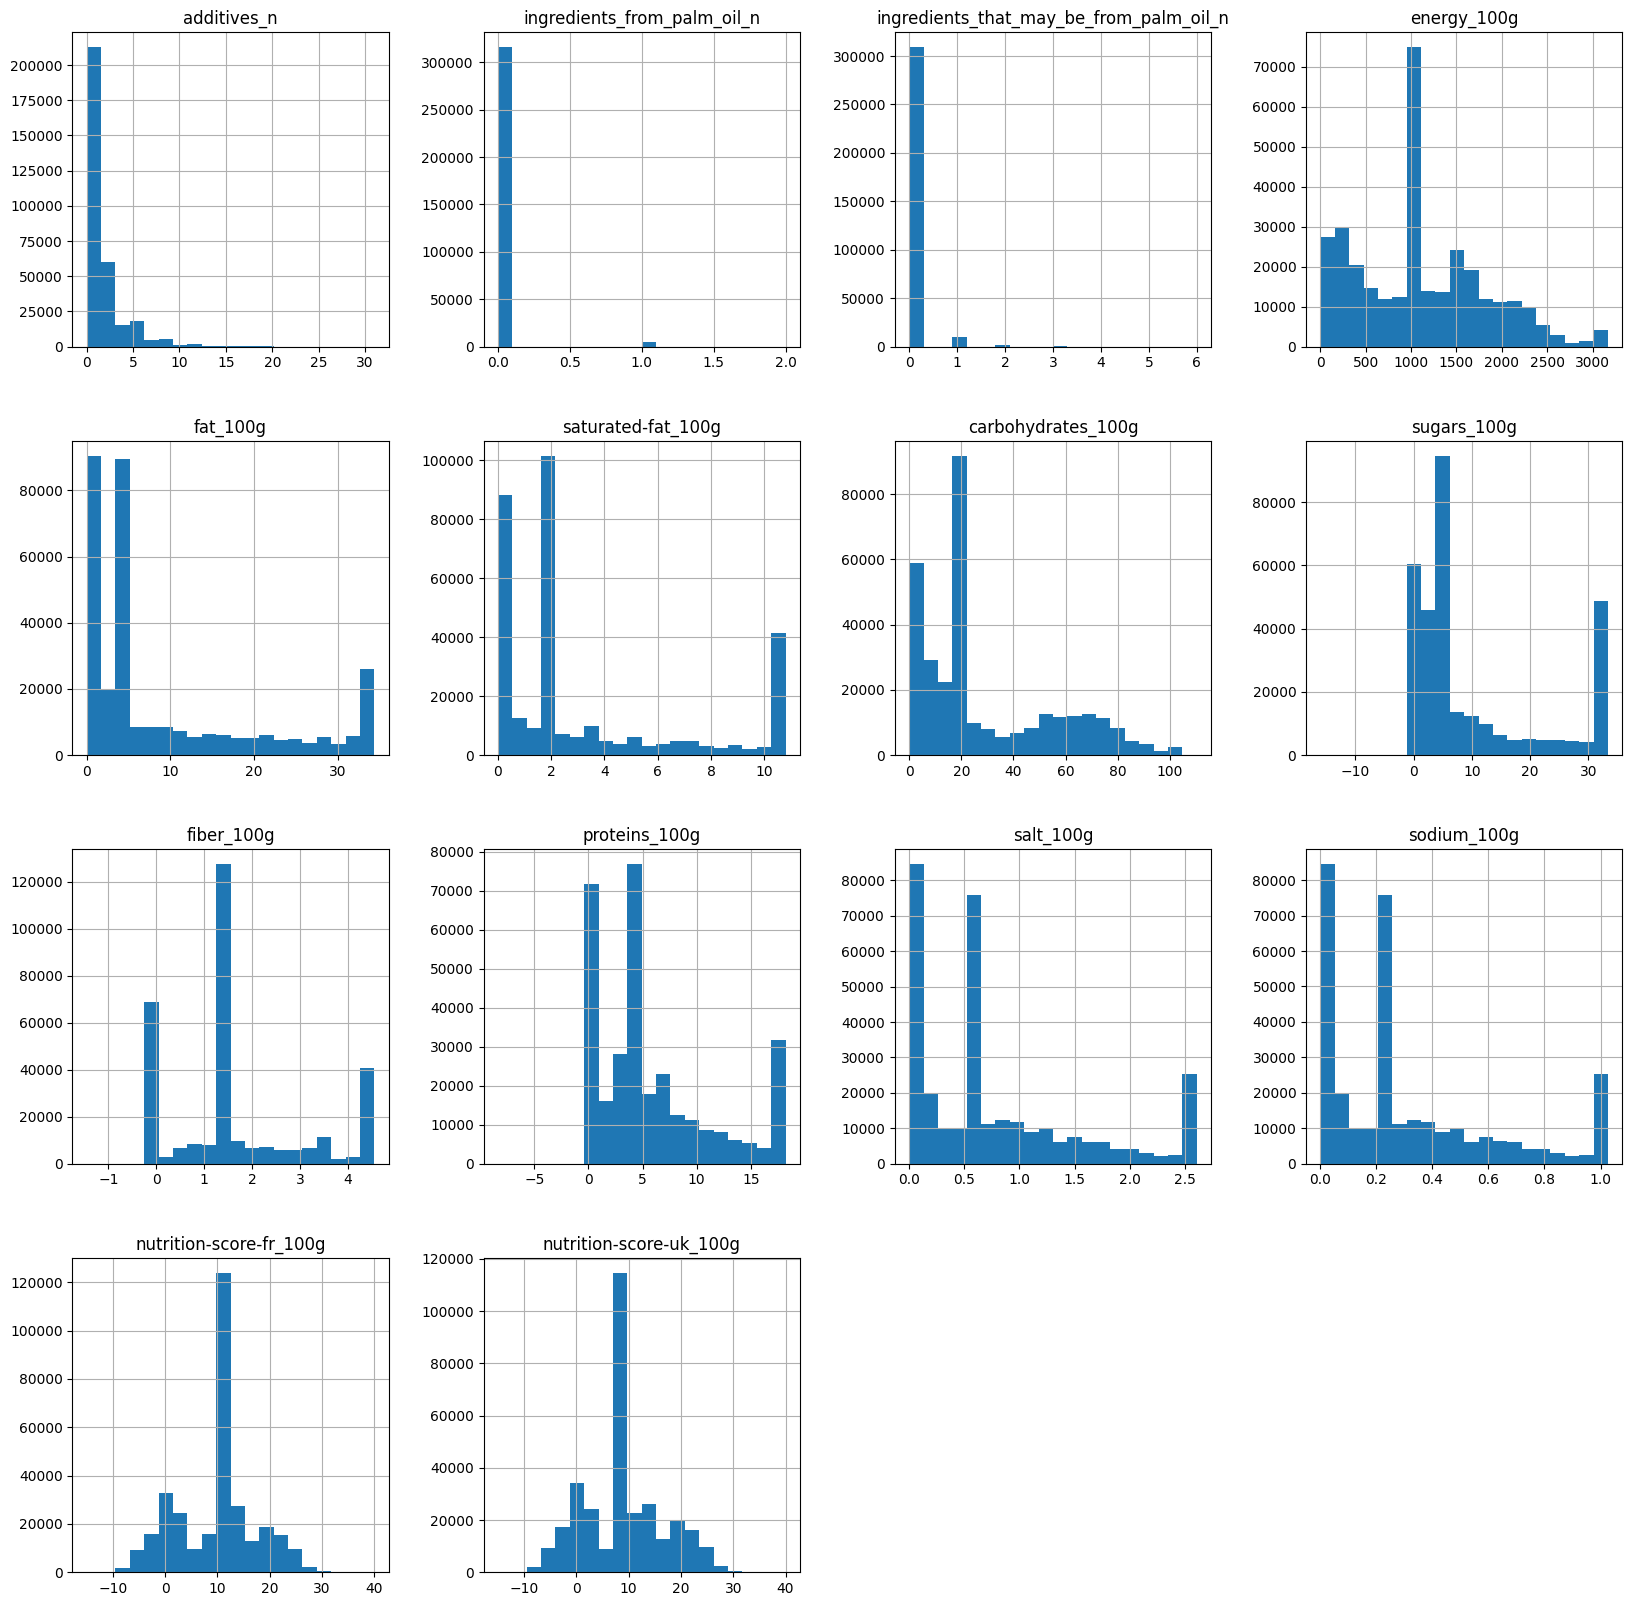

In [5]:
df.hist(figsize=(20,20), bins=20)

# Notes 

- quantative ~ quantative
- quantative ~ qualataive
    - eta_squared, linear regression
- qualtative ~ qualitataive


PCA
- Statistics
- Visualisations